In [1]:
import seaborn as sns
import metapack as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display 

%matplotlib inline
sns.set_context('notebook')
mp.jupyter.init()

from statsmodels.nonparametric.smoothers_lowess import lowess

In [2]:
pkg = mp.jupyter.open_package()
#pkg = mp.jupyter.open_source_package()
pkg

# San Diego Pedestrian Counts
`cityiq.io-pedestrians-san_diego-1` Last Update: 2020-04-21T00:04:49

_Counts of pedestrian traffic from the San Diego CityIQ system_


This dataset is pedestrian directions and counts for walkwaks in the San Diego
CityIQ system. The package includes pedestrian counts for most walkway
locations in the San Diego CityIQ system, but not all of them. The date range
for the data is 1 August 2018 to the last full month before the package was
built. For Version 1, then end date is 1 June 2019.


## Building the Source Package 

Before generating this package, you must have scraped all of the events to be
included in the package. After creating a ``.city-iq.yaml`` configuration file,
run:

    $ ciq_events -s ped # Scrape the events
    $ ciq_aggregate ped # Convert JSON to CSV
    
The first process ``ciq_events`` may run for several days and consume up to
300G of disk space. The second process, ``ciq_aggregate`` may run for a few
hours and consume a few more gigabytes of disk space.


 

## Contacts

* **Wrangler** [Eric Busboom](mailto:eric@civicknowledge.com), [Civic Knowledge](http://civicknowledge.com)

## Resources

* ** [pedestrians](data/pedestrians.csv)**. Pedestrians

In [3]:
%%time
df = pkg.resource('pedestrians').read_csv()
df['timestamp'] = pd.to_datetime(df.timestamp)
len(df)

CPU times: user 18.2 s, sys: 3.3 s, total: 21.5 s
Wall time: 21.6 s


31934196

Text(0, 0.5, 'Numer of Walkways (Log)')

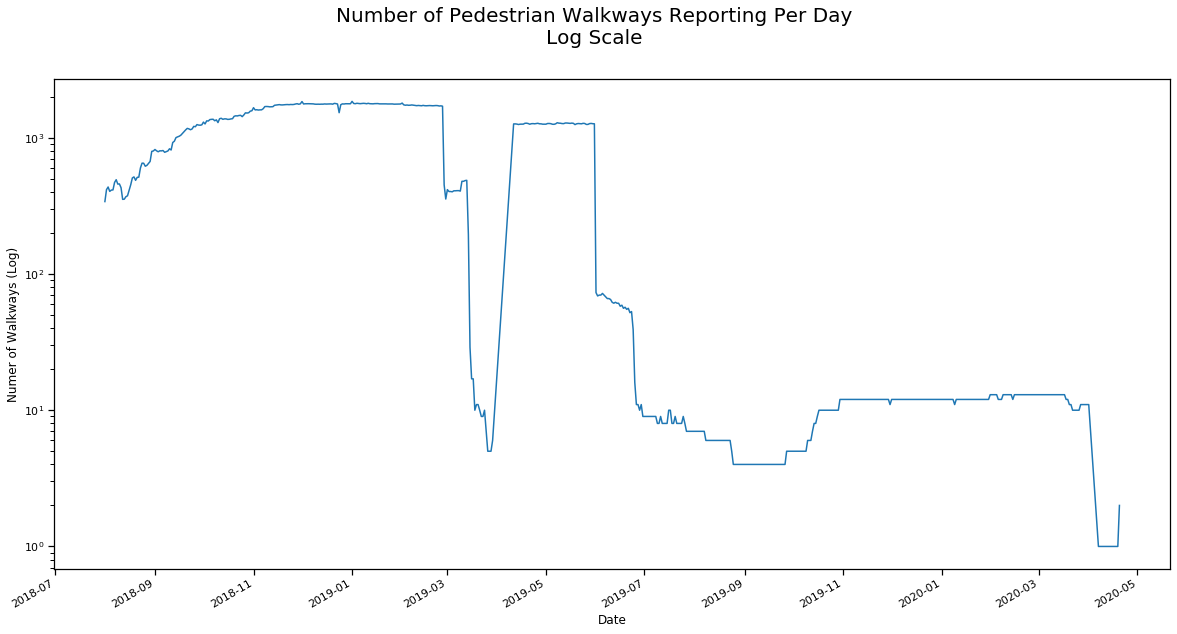

In [109]:
fig, ax = plt.subplots(figsize=(20,10))

df_1d = df.groupby([pd.Grouper(key='timestamp', freq='1D'),'locationuid']).sum().rename(columns={'count':'ped_count'})[['ped_count']]
t = df_1d.reset_index().groupby('timestamp').count()
t.ped_count.plot()
ax.set_yscale('log')

fig.suptitle("Number of Pedestrian Walkways Reporting Per Day\nLog Scale", fontsize=20);
ax.set_xlabel('Date')
ax.set_ylabel('Numer of Walkways (Log)')


Text(0, 0.5, 'Numer of Walkways')

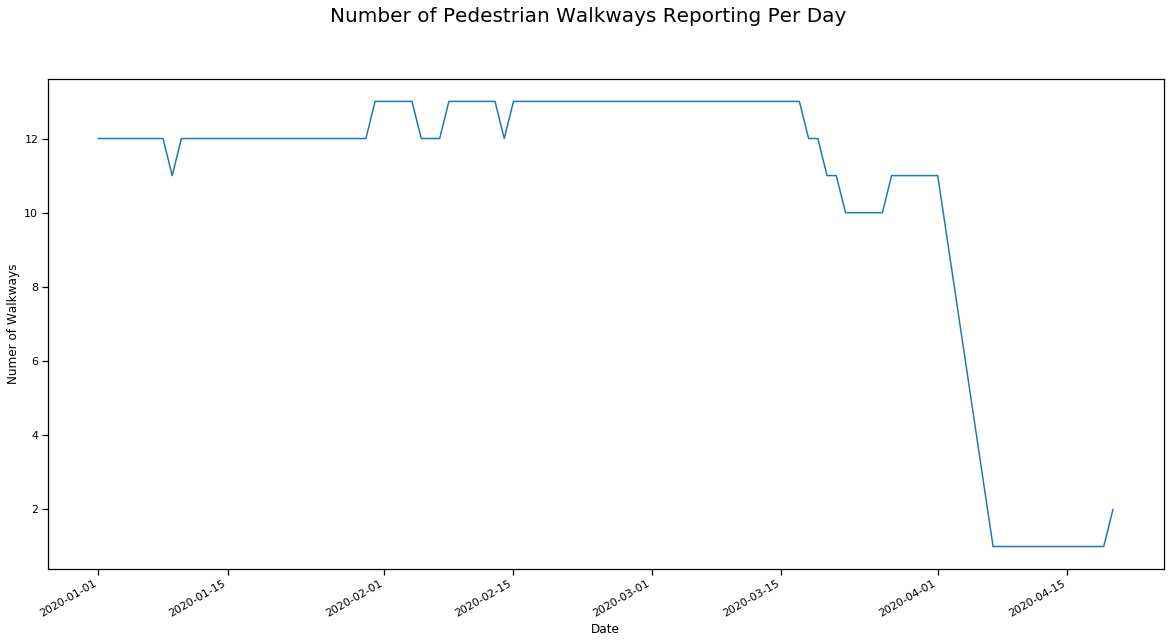

In [119]:
fig, ax = plt.subplots(figsize=(20,10))

t.loc['2020-01-01':].ped_count.plot()
#ax.set_yscale('log')

fig.suptitle("Number of Pedestrian Walkways Reporting Per Day", fontsize=20);
ax.set_xlabel('Date')
ax.set_ylabel('Numer of Walkways')


In [100]:
dfy20 = df[ (df.timestamp.dt.year == 2020) & ( df.timestamp.dt.month < 4)].copy()
dfy20_15 = dfy20.groupby([pd.Grouper(key='timestamp', freq='15T'),'locationuid']).sum().rename(columns={'count':'ped_count'})[['ped_count']]
dfy20_15.head()

ped_count
timestamp  locationuid                   
2020-01-01 0r6lsttjytwk2cd4t6s         16
           237f1aeb                    25
           680d989e                     2
           872148fd                    13
           alspchkqad7k1jua5jg         15

In [102]:
# Portion of 15 minut intervals where location has some traffic. 
t15minday = 24 * 4
t = dfy20_15.reset_index().groupby([pd.Grouper(key='timestamp', freq='1D'),'locationuid']).count() 


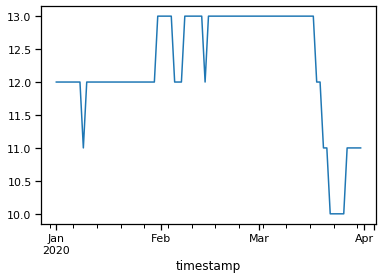

In [105]:
dfy20_1d = dfy20.groupby([pd.Grouper(key='timestamp', freq='1D'),'locationuid']).sum().rename(columns={'count':'ped_count'})[['ped_count']]
t = dfy20_1d.reset_index().groupby('timestamp').count()
t.ped_count.plot()

In [ ]:
cv = pd.read_csv('covid-19.csv')
cv.columns = ['date','covid-19','coronavirus']
cv = cv.iloc[2:]
cv['date'] = pd.to_datetime(cv.date)
cv['coronavirus'] = pd.to_numeric(cv.coronavirus)
cv['coronavirus'] = cv.coronavirus/cv.coronavirus.max()
cv

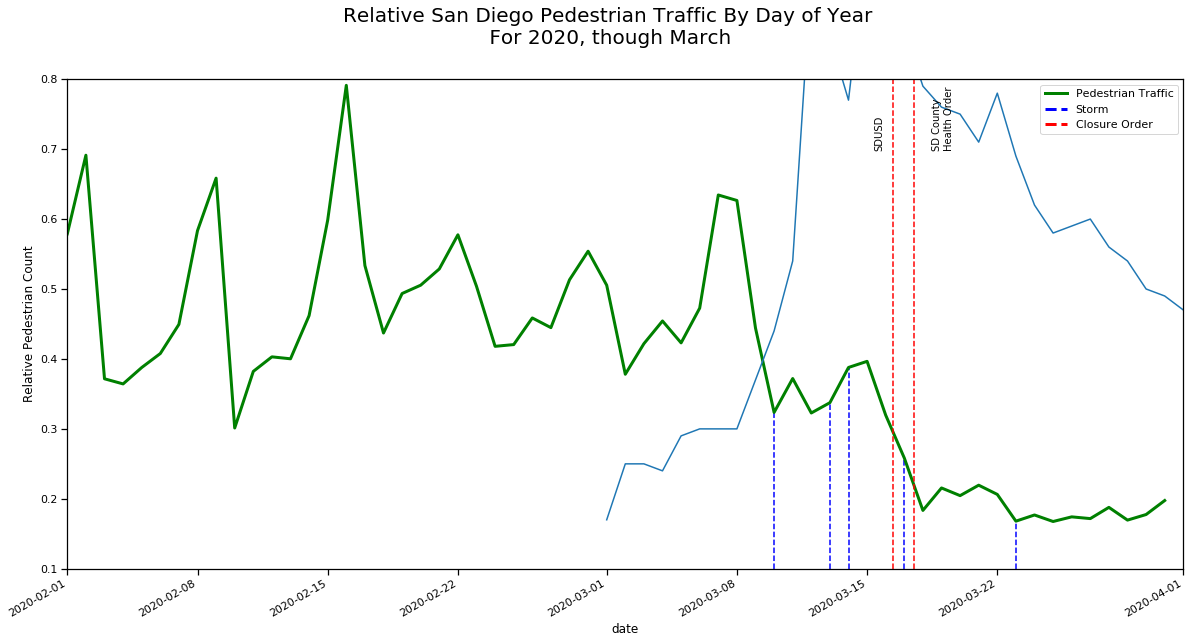

In [158]:
from matplotlib.lines import Line2D

ymin = .1

dfy20 = df[ (df.timestamp.dt.year == 2020) & ( df.timestamp.dt.month < 4)].copy()

dfy20_d = dfy20.set_index(dfy20.timestamp).resample('D').sum().rename(columns={'count':'ped_count'})[['ped_count']]

fig, ax = plt.subplots(figsize=(20,10))

smooth = lowess(dfy20_d.ped_count,dfy20_d.index, frac=.05)[:,1]
 
smooth = smooth/np.max(smooth)
smooth = (dfy20_d.ped_count/dfy20_d.ped_count.max()).values
    
data_min = np.min(smooth)

sns.lineplot(dfy20_d.index,smooth, ax=ax, linewidth=3, color='green', label='pedestrian traffic')
    
fig.suptitle("Relative San Diego Pedestrian Traffic By Day of Year\n For 2020, though March", fontsize=20);

ax.set_xlabel('Date')
ax.set_ylabel('Relative Pedestrian Count');

storms = [
    ('2020-03-10', .77 ),
    ('2020-03-13', 1.97),
    ('2020-03-14', .43),
    ('2020-03-17', .49),
    ('2020-03-23', .73)]

for date, amnt in storms:
    ts = pd.Timestamp(f'{date} 00:00:00', freq='D')
    
    v = smooth[(np.abs(dfy20_d.index-ts).days).argmin()]
  
    ax.vlines(x=ts, ymin=ymin, ymax=v, color='blue', linestyle='dashed')
    
    #ax.text(ts-1,.90, f'Storm {amnt}\"', rotation=90)

ax.axvline(x=pd.Timestamp('2020-03-16 9:00:00'), color='Red', linestyle='dashed');
ax.text(pd.Timestamp('2020-03-16 9:00:00', freq='D')-1,.70, 'SDUSD', rotation=90)

ax.axvline(x=pd.Timestamp('2020-03-17 12:00:00'), color='Red', linestyle='dashed');
ax.text(pd.Timestamp('2020-03-17 12:00:00', freq='D')+1,.70, 'SD County\nHealth Order', rotation=90)

ax.set_xlim(pd.Timestamp('2020-02-01'), pd.Timestamp('2020-04-01') )
ax.set_ylim(ymin, .8)

colors = ['blue', 'red']
labels = ['Pedestrian Traffic', 'Storm', 'Closure Order']
lines = [Line2D([0], [0], color='green', linewidth=3, linestyle='-') ] + \
        [Line2D([0], [0], color=c, linewidth=3, linestyle='--') for c in colors] 
        
plt.legend(lines, labels, loc='upper left', fontsize=16)

cv.set_index('date').coronavirus.plot()

plt.show()


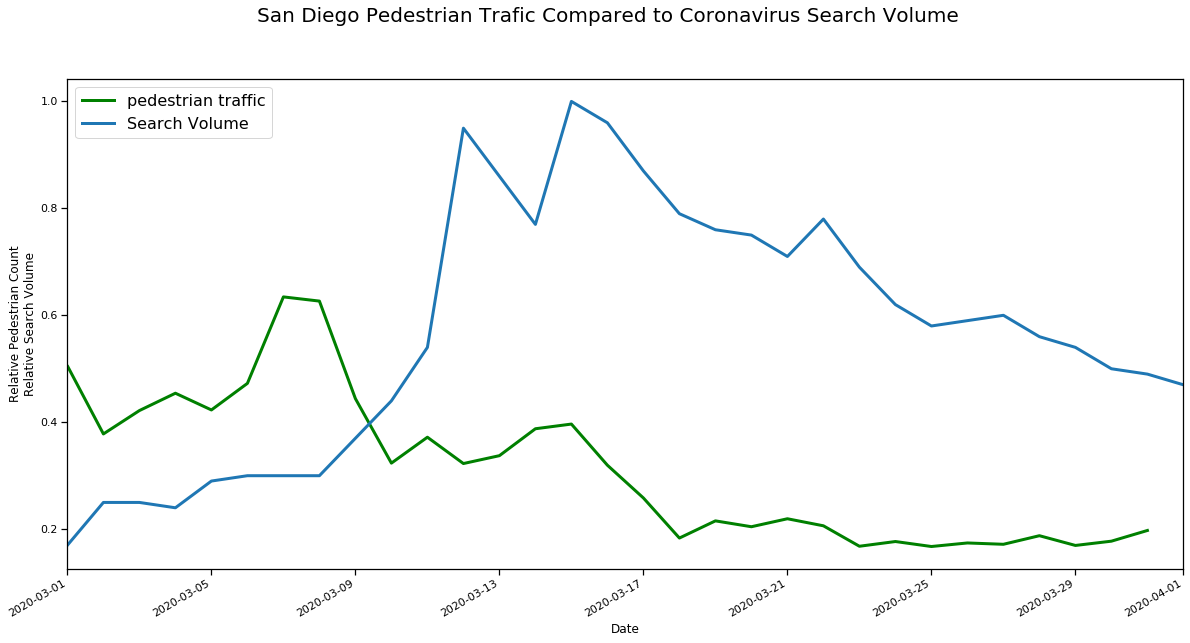

In [172]:
fig, ax = plt.subplots(figsize=(20,10))

sns.lineplot(dfy20_d.index,smooth, ax=ax, linewidth=3, color='green', label='pedestrian traffic') 
cv.set_index('date').coronavirus.plot(label='Search Volume', linewidth=3)

fig.suptitle("San Diego Pedestrian Trafic Compared to Coronavirus Search Volume", fontsize=20);
ax.set_xlabel('Date')
ax.set_ylabel('Relative Pedestrian Count\nRelative Search Volume');

ax.set_xlim(cv.date.min(), cv.date.max())
plt.legend( loc='upper left', fontsize=16)


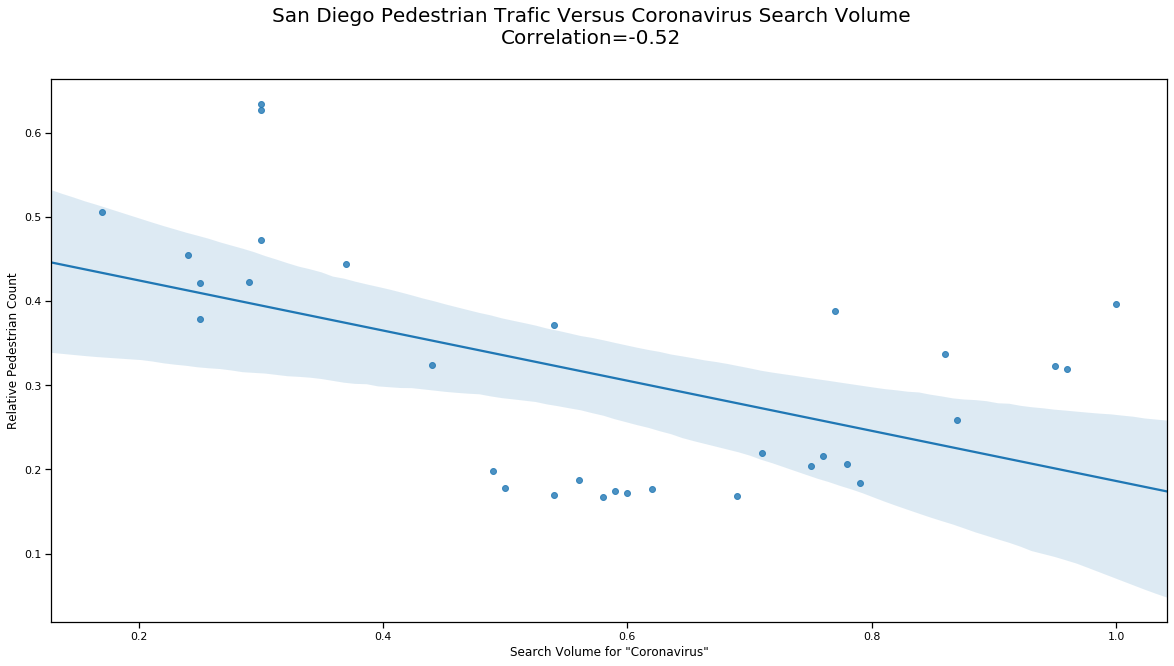

In [180]:
fig, ax = plt.subplots(figsize=(20,10))

t = pd.DataFrame({'ped':smooth}, index = dfy20_d.index)
t = cv.set_index('date').join(t)

sns.regplot('coronavirus','ped',data=t)

fig.suptitle(f"San Diego Pedestrian Trafic Versus Coronavirus Search Volume\nCorrelation={round(t.coronavirus.corr(t.ped), 2)}", fontsize=20);
ax.set_xlabel('Search Volume for \"Coronavirus\"')
ax.set_ylabel('Relative Pedestrian Count');

#plt.legend( loc='upper left', fontsize=16)



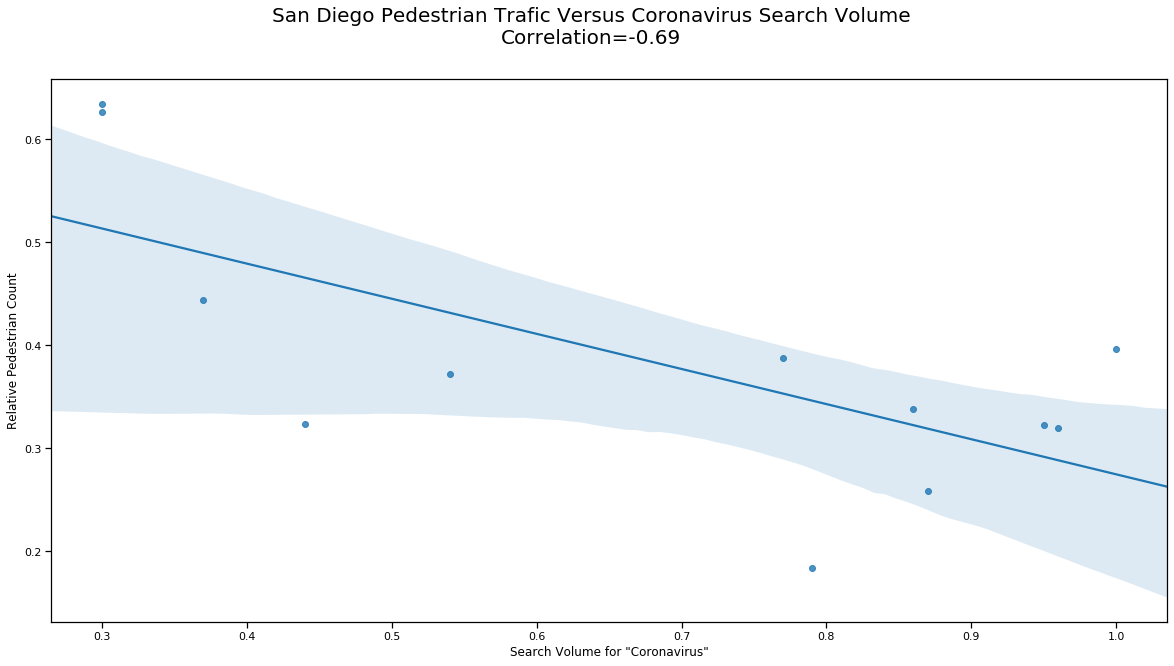

In [182]:
fig, ax = plt.subplots(figsize=(20,10))

t = pd.DataFrame({'ped':smooth}, index = dfy20_d.index)
t = cv.set_index('date').join(t)
t = t['2020-03-07':'2020-03-18']
sns.regplot('coronavirus','ped',data=t)

fig.suptitle(f"San Diego Pedestrian Trafic Versus Coronavirus Search Volume\nCorrelation={round(t.coronavirus.corr(t.ped), 2)}", fontsize=20);
ax.set_xlabel('Search Volume for \"Coronavirus\"')
ax.set_ylabel('Relative Pedestrian Count');

#plt.legend( loc='upper left', fontsize=16)

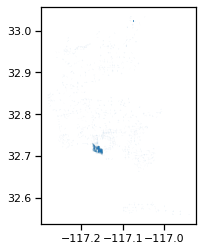

In [78]:
pkg = mp.open_package('http://library.metatab.org/cityiq.io-objects-san_diego-5.zip')
walkways_gdf = pkg.resource('walkways').geoframe()
walkways_gdf.plot()

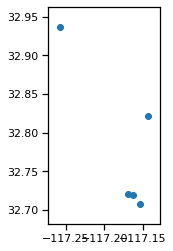

In [137]:

t = walkways_gdf.merge(dfy20.locationuid.drop_duplicates().to_frame(), on='locationuid')
t.centroid.plot()

In [138]:
dfy20.locationuid.drop_duplicates().to_frame()

,locationuid
4339509,237f1aeb
7111390,2ebbf6e2
11825280,680d989e
16740804,872148fd
22123093,alspchkqad7k1jua5jg
22515577,b7gv7mosiuk1tr3t6i
23962681,c3fff0cf
24513127,c9iznoghoh7k1mj2oiu
31816102,gqgkrvlbtajk10zq3oi
31840267,ndy4qdunwwmk1mhv26k


,date,covid-19,coronavirus
2,2020-03-01,<1,0.17
3,2020-03-02,<1,0.25
4,2020-03-03,<1,0.25
5,2020-03-04,<1,0.24
6,2020-03-05,1,0.29
7,2020-03-06,1,0.30
8,2020-03-07,1,0.30
9,2020-03-08,1,0.30
10,2020-03-09,1,0.37
11,2020-03-10,1,0.44
